In [1]:
# mounting drive to get train and test images and annonation txt files
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Import libraries

# python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import zipfile
import shutil
import os 

# keras and tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [ ]:
def data_generators(preprocessing): 

    # All models we consider will have this target size requirement
    target_size=(224,224)

    train_datagen = ImageDataGenerator(preprocessing_function=preprocessing) 
    
    test_datagen = ImageDataGenerator(preprocessing_function=preprocessing)


    train_dataset = train_datagen.flow_from_directory('/content/drive/MyDrive/Bird Species Detection/Train',
                                            target_size= target_size, 
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=64
    )
    
    test_dataset = test_datagen.flow_from_directory('/content/drive/MyDrive/Bird Species Detection/Test',
                                            target_size= target_size,
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32
    )


    return train_dataset, test_dataset

In [3]:
# define function to plot results

def plot_history(history, yrange):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy per epoch
    plt.subplot(1,2,1)
    plt.plot(epochs, acc,  label='Train')
    plt.plot(epochs, val_acc , label='Val')
    
    plt.title('Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(yrange)
    plt.legend(['Train', 'Val'], loc='lower right')
    
    # Plot training and validation loss per epoch
    #plt.figure()
    plt.subplot(1,2,2)
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    
    plt.title('Classification Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    
    #plt.show()
    plt.tight_layout()

Found 4829 images belonging to 200 classes.


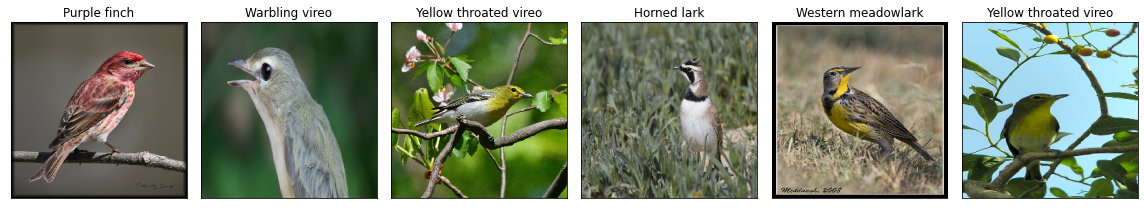

In [ ]:
# Visualise some images from the dataset
# create a variable with the unscaled data so we can visualise it
viz_im = ImageDataGenerator()
x_viz = viz_im.flow_from_directory('/content/drive/MyDrive/Bird Species Detection/Train', batch_size=16)

bird_dict = x_viz.class_indices
label_list = {v: k.lower().capitalize() for k, v in bird_dict.items()}
label_list


for X, y in x_viz:
    fig, ax = plt.subplots(1, 6, figsize=(16, 16))
    
    for i in range(6):
        img = X[i].astype(np.uint8)
        label = label_list[np.argmax(y[i])]

        ax[i].imshow(img)
        ax[i].set_title(label)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    
    plt.tight_layout()
    break # We only need the first batch

In [4]:
# define function for testing the models

from keras.preprocessing import image
import random

def model_tester(full_model):
    
    %matplotlib inline

    # This first part selects a random file from the validation directory
    type = random.choice(os.listdir('/content/drive/MyDrive/Bird Species Detection/Test'))
    #print(type)
    file = random.choice(os.listdir(f'/content/drive/MyDrive/Bird Species Detection/Test/{type}'))
    #print(file)

    random_path = '/content/drive/MyDrive/Bird Species Detection/Test' + '/' + type + '/' + file
    #print(random_path)

    # We then create the list of labels 
    bird_dict = train_dataset.class_indices
    label_list = {v: k.lower().capitalize() for k, v in bird_dict.items()}
    label_list

    # We then select the image, preprocess and predict the values from full_model
    img_path = random_path
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    answer=full_model.predict(x)
    probability=round(np.max(full_model.predict(x)*100),2)
    
    # Prediction
    print ('This model suggests the image below is a: ',
           label_list[np.argmax(full_model.predict(x)*100)],
           ' with a probability of' ,probability,'%' ) 
    
    plt.imshow(img) 
   
    # Ground Truth
    print('____________________________________')
    print('The ground truth is:  ' ,type)
    print('____________________________________\n')


    #If we want to display the next two likely outcomes we can use:
    z = full_model.predict(x)*100
    temp = np.argpartition(z[0], -3)[-3:]
    #print(temp)
    #print(z[0][temp])
    temp = np.argsort(-z[0])[:3]

    print('The two next most likely choices are: \n', 
            '          ' , label_list[temp[1]], 'with probability', round(z[0][temp][1], 2),'% \n', 
            '          ' , label_list[temp[2]], 'with probability', round(z[0][temp][2], 2), '%' )
    print('____________________________________')

# Build model (VGG16)

In [ ]:
# Import relavant keras libraries
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

vgg16 = keras.applications.vgg16

full_vgg16 = vgg16.VGG16(weights='imagenet', input_shape=(224, 224, 3))

full_vgg16.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
conv_vgg16 = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3) )

conv_vgg16.summary()

inputs = conv_vgg16.input
outputs = conv_vgg16.output

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
conv_vgg16.trainable = False

# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_vgg16.output)
# two hidden layers
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)

# final softmax layer 200 classes of birds
pred_x = keras.layers.Dense(200, activation='softmax')(x)

# creating the full model:
full_model_categorical = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_x)
full_model_categorical.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# This output shows us that the parameters in the first layers arent trainable. 
full_model_categorical = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_x)
full_model_categorical.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
train_dataset, test_dataset = data_generators(preprocessing=vgg16.preprocess_input)

Found 4829 images belonging to 200 classes.
Found 1204 images belonging to 200 classes.


In [ ]:
full_model_categorical.compile(loss='sparse_categorical_crossentropy',
                               optimizer=keras.optimizers.Nadam(learning_rate=0.001),
                               metrics=['accuracy'])

history_categorical = full_model_categorical.fit ( train_dataset, 
                                                  validation_data = test_dataset, 
                                                  workers = 10, 
                                                  epochs=7 )

Epoch 1/7
76/76 [==============================] - 3024s 40s/step - loss: 5.4537 - accuracy: 0.0474 - val_loss: 4.3261 - val_accuracy: 0.1279
Epoch 2/7
76/76 [==============================] - 2995s 39s/step - loss: 3.3363 - accuracy: 0.2595 - val_loss: 3.2026 - val_accuracy: 0.2691
Epoch 3/7
76/76 [==============================] - 2959s 39s/step - loss: 2.2200 - accuracy: 0.4668 - val_loss: 2.7721 - val_accuracy: 0.3613
Epoch 4/7
76/76 [==============================] - 2985s 39s/step - loss: 1.4400 - accuracy: 0.6471 - val_loss: 2.5714 - val_accuracy: 0.4103
Epoch 5/7
76/76 [==============================] - 3007s 40s/step - loss: 0.9312 - accuracy: 0.7793 - val_loss: 2.5258 - val_accuracy: 0.4211
Epoch 6/7
76/76 [==============================] - 2989s 39s/step - loss: 0.6258 - accuracy: 0.8596 - val_loss: 2.4638 - val_accuracy: 0.4452
Epoch 7/7
76/76 [==============================] - 3024s 40s/step - loss: 0.4092 - accuracy: 0.9159 - val_loss: 2.4351 - val_accuracy: 0.4502


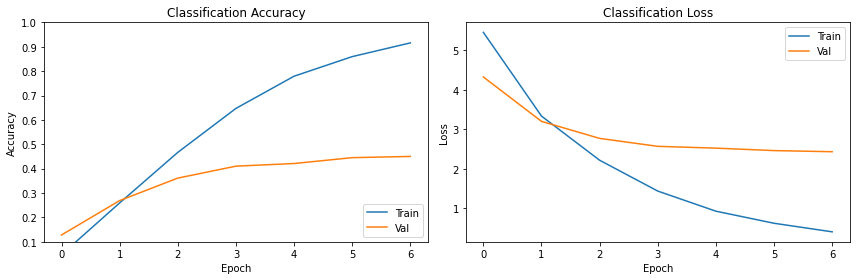

In [ ]:
# Plot our results and save val_accuracy to compare in future

vgg16_train_acc_cat = history_categorical.history['accuracy']
vgg16_val_acc_cat = history_categorical.history['val_accuracy']

plot_history(history_categorical, yrange=(0.1,1))

This model suggests the image below is a:  Gray crowned rosy finch  with a probability of 55.1 %
____________________________________
The ground truth is:   Chuck will Widow
____________________________________

The two next most likely choices are: 
            Cliff swallow with probability 10.28 % 
            Whip poor will with probability 2.67 %
____________________________________


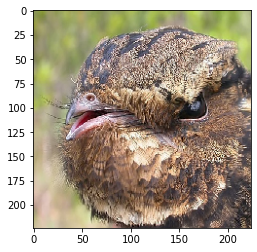

In [ ]:
# Try using the function to predict:

model_tester(full_model=full_model_categorical)

This model suggests the image below is a:  Parakeet auklet  with a probability of 22.85 %
____________________________________
The ground truth is:   Parakeet Auklet
____________________________________

The two next most likely choices are: 
            Crested auklet with probability 17.99 % 
            Least auklet with probability 4.42 %
____________________________________


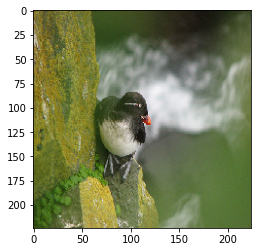

In [ ]:
model_tester(full_model=full_model_categorical)

This model suggests the image below is a:  Scissor tailed flycatcher  with a probability of 99.51 %
____________________________________
The ground truth is:   Scissor tailed Flycatcher
____________________________________

The two next most likely choices are: 
            Lazuli bunting with probability 0.15 % 
            Henslow sparrow with probability 0.05 %
____________________________________


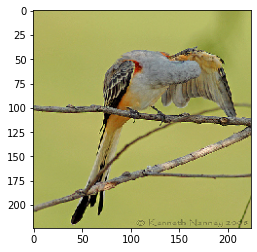

In [ ]:
model_tester(full_model=full_model_categorical)

In [ ]:
full_model_categorical.save_weights('/content/drive/MyDrive/Bird Species Detection/VGG16/WeightsOnly/model1.h5')
full_model_categorical.save('/content/drive/MyDrive/Bird Species Detection/VGG16/FullModel/model1.h5')
print('Saved Model!')

Saved Model!


In [25]:
# Import relavant keras libraries
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

vgg16 = keras.applications.vgg16

def create_model():

    conv_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3) ) 
    inputs = conv_vgg16.input
    outputs = conv_vgg16.output
    
    conv_vgg16.trainable = False

    y = keras.layers.Flatten()(conv_vgg16.output)
    # two hidden layers
    y = keras.layers.Dense(512, activation='relu')(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.5)(y)

    y = keras.layers.Dense(512, activation='relu')(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.5)(y)

    # final softmax layer 200 classes of birds
    pred_y = keras.layers.Dense(200, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Nadam(learning_rate=0.001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optim, 
                  metrics=['accuracy'])
    
    return model

In [ ]:
total_images = test_dataset.n  
steps = total_images//32  ## 32 is batch size
#iterations to cover all data. We add 1 to the step size to account for not integer division i.e. the remaining 2 data points in the last batch

_ , ground_truth = [] , []
for i in range(steps + 1 ):
    _ , b = test_dataset.next() 

    ground_truth.extend(b)


groundT= [int(x) for x in ground_truth]
preds = list(np.argmax(predictions, axis=1))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print('Classification Report')
target_names =  list(test_dataset.class_indices.keys())
print(classification_report(groundT, preds))

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         5
          10       0.00      0.20      0.01         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         7
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         7
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Build Model (Xception)

In [6]:
def data_generators(preprocessing): 

    # Xception has the image size requirement of (299,299)
    target_size=(299,299)

    train_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing,
                                         horizontal_flip=True)
    
    # Seperate test gen so we don't augment test data. 
    test_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing)

    train_dataset = train_imdatagen.flow_from_directory('/content/drive/MyDrive/Bird Species Detection/Train',
                                            target_size= target_size,
                                            class_mode= 'sparse', 
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32
    )
    
    test_dataset = test_imdatagen.flow_from_directory('/content/drive/MyDrive/Bird Species Detection/Test',
                                            target_size= target_size,
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )


    return train_dataset, test_dataset

In [7]:
def plot_history(history, yrange):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy per epoch
    plt.subplot(1,2,1)
    plt.plot(epochs, acc,  label='Train')
    plt.plot(epochs, val_acc , label='Val')
    
    plt.title('Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(yrange)
    plt.legend(['Train', 'Val'], loc='lower right')
    
    # Plot training and validation loss per epoch
    #plt.figure()
    plt.subplot(1,2,2)
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    
    plt.title('Classification Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    
    #plt.show()
    plt.tight_layout()

Found 4829 images belonging to 200 classes.


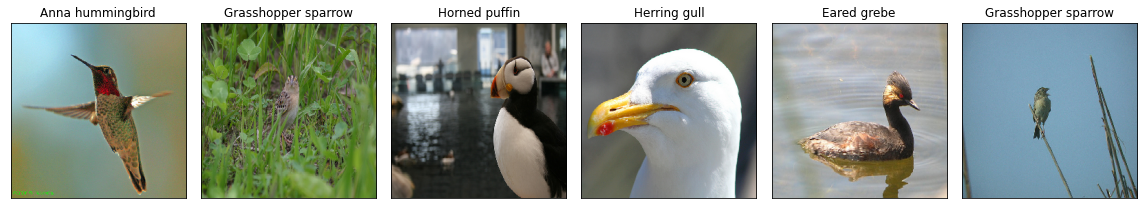

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# create a variable with the unscaled data so we can visualise it
viz_im = ImageDataGenerator()
x_viz = viz_im.flow_from_directory('/content/drive/MyDrive/Bird Species Detection/Train', batch_size=16)

bird_dict = x_viz.class_indices
label_list = {v: k.lower().capitalize() for k, v in bird_dict.items()}
label_list


for X, y in x_viz:
    fig, ax = plt.subplots(1, 6, figsize=(16, 16))
    
    for i in range(6):
        img = X[i].astype(np.uint8)
        label = label_list[np.argmax(y[i])]

        ax[i].imshow(img)
        ax[i].set_title(label)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    
    plt.tight_layout()
    break # We only need the first batch

In [9]:
from keras.preprocessing import image
import random

def model_tester(full_model):
    
    %matplotlib inline

    # This first part selects a random file from the validation directory
    type = random.choice(os.listdir('/content/drive/MyDrive/Bird Species Detection/Test'))
    #print(type)
    file = random.choice(os.listdir(f'/content/drive/MyDrive/Bird Species Detection/Test/{type}'))
    #print(file)

    random_path = '/content/drive/MyDrive/Bird Species Detection/Test' + '/' + type + '/' + file
    #print(random_path)

    # We then create the list of labels 
    bird_dict = train_dataset.class_indices
    label_list = {v: k.lower().capitalize() for k, v in bird_dict.items()}
    label_list

    # We then select the image, preprocess and predict the values from full_model
    img_path = random_path
    img = image.load_img(img_path, target_size=(299,299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    answer=full_model.predict(x)
    probability=round(np.max(full_model.predict(x)*100),2) # We could get the top n here and see if it comes in the top 5 instead of max. 
    
    # Prediction
    print ('This model suggests the image below is a: ',label_list[np.argmax(full_model.predict(x)*100)], ' with a probability of' ,probability,'%' )  # argmax pulls out the first occurence of the max arguement. This is fine for use becuase the softmax should only produce one highest value 
    
    plt.imshow(img) 
   
    # Ground Truth
    print('____________________________________')
    print('The ground truth is:  ' ,type)
    print('____________________________________\n')


    #If we want to display the next two likely outcomes we can use:
    z = full_model.predict(x)*100
    temp = np.argpartition(z[0], -3)[-3:]
    #print(temp)
    #print(z[0][temp])
    temp = np.argsort(-z[0])[:3]

    print('The two next most likely choices are: \n', 
            '          ' , label_list[temp[1]], 'with probability', round(z[0][temp][1], 2),'% \n', 
            '          ' , label_list[temp[2]], 'with probability', round(z[0][temp][2], 2), '%' )
    print('____________________________________')

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation
from keras.applications.xception import Xception
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.xception import preprocess_input
from keras.applications.xception import decode_predictions

xception = keras.applications.xception

def create_model():

    first_part_xception = xception.Xception(weights='imagenet', include_top=False, 
                input_shape=(299, 299, 3) ) # can add pooling='max' here instead of flattening for the dense layers

    inputs = first_part_xception.input
    outputs = first_part_xception.output
    first_part_xception.trainable = False

    y = keras.layers.Flatten()(outputs)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # two hidden layers
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.30)(y)

    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)

    # final softmax layer 200 classes of birds
    pred_y = keras.layers.Dense(200, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Nadam(learning_rate=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

print('Done!')

Done!


In [14]:
train_dataset, test_dataset = data_generators(preprocessing = xception.preprocess_input)

Found 4829 images belonging to 200 classes.
Found 1204 images belonging to 200 classes.


In [15]:
model = create_model()

history = model.fit(train_dataset, validation_data=test_dataset, workers=10, epochs=10)

83697664/83683744 [==============================] - 1s 0us/step
Epoch 1/10
151/151 [==============================] - 1939s 13s/step - loss: 5.0039 - accuracy: 0.0615 - val_loss: 4.1076 - val_accuracy: 0.2201
Epoch 2/10
151/151 [==============================] - 1903s 13s/step - loss: 3.7444 - accuracy: 0.2346 - val_loss: 3.5837 - val_accuracy: 0.2841
Epoch 3/10
151/151 [==============================] - 1932s 13s/step - loss: 3.0775 - accuracy: 0.3609 - val_loss: 3.1981 - val_accuracy: 0.3754
Epoch 4/10
151/151 [==============================] - 1937s 13s/step - loss: 2.5984 - accuracy: 0.4765 - val_loss: 2.9601 - val_accuracy: 0.4111
Epoch 5/10
151/151 [==============================] - 1932s 13s/step - loss: 2.1613 - accuracy: 0.5925 - val_loss: 2.7982 - val_accuracy: 0.4502
Epoch 6/10
151/151 [==============================] - 1917s 13s/step - loss: 1.8620 - accuracy: 0.6604 - val_loss: 2.6855 - val_accuracy: 0.4684
Epoch 7/10
151/151 [==============================] - 1926s 13s/s

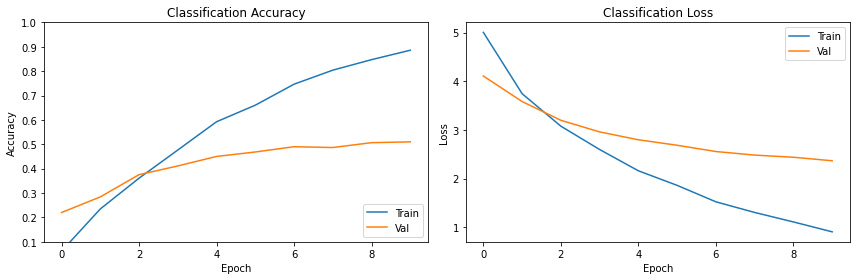

In [16]:
# plot the results
plot_history(history, (0.1,1))

This model suggests the image below is a:  Red headed woodpecker  with a probability of 39.73 %
____________________________________
The ground truth is:   Cliff Swallow
____________________________________

The two next most likely choices are: 
            Cliff swallow with probability 12.31 % 
            Yellow headed blackbird with probability 2.32 %
____________________________________


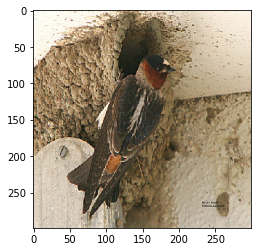

In [18]:
model_tester(full_model=model)

This model suggests the image below is a:  Brandt cormoran  with a probability of 53.12 %
____________________________________
The ground truth is:   Brandt Cormorant
____________________________________

The two next most likely choices are: 
            Frigatebird with probability 13.76 % 
            Fish crow with probability 4.8 %
____________________________________


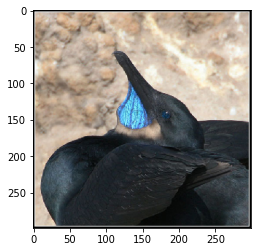

In [19]:
model_tester(full_model=model)

This model suggests the image below is a:  Black footed albatross  with a probability of 79.71 %
____________________________________
The ground truth is:   Black footed Albatross
____________________________________

The two next most likely choices are: 
            Sooty albatross with probability 12.74 % 
            Northern fulmar with probability 1.13 %
____________________________________


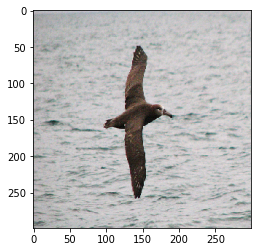

In [20]:
model_tester(full_model=model)

In [21]:
model.save_weights('/content/drive/MyDrive/Bird Species Detection/Xception/WeightsOnly/model2.h5')
model.save('/content/drive/MyDrive/Bird Species Detection/Xception/FullModel/model2.h5')

print("Saved Model!")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved Model!


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Create a Callback function becuase Azure is being moody and stopping after 2 epochs!


checkpoint_path = "/content/drive/MyDrive/Bird Species Detection/Xception/WeightsOnly/model2.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True,
                             monitor='val_accuracy', 
                             verbose=1, mode='max',
                             save_best_only=True)

checkpoint_list = [checkpoint]

# Load the Xception model and train for another 10 epochs
<p>Train the model and monitor the val_accuracy to see if it improves.</p>

In [24]:
full_model = create_model()
full_model.load_weights('/content/drive/MyDrive/Bird Species Detection/Xception/WeightsOnly/model2.h5')
history = full_model.fit ( train_dataset, 
                          validation_data = test_dataset, 
                          workers = 10, 
                          epochs=10, 
                          callbacks=checkpoint_list)

Epoch 1/10
151/151 [==============================] - 1920s 13s/step - loss: 0.9039 - accuracy: 0.8869 - val_loss: 2.3609 - val_accuracy: 0.5083

Epoch 00001: val_accuracy improved from -inf to 0.50831, saving model to /content/drive/MyDrive/Bird Species Detection/Xception/WeightsOnly/model2.ckpt
Epoch 2/10
151/151 [==============================] - 1940s 13s/step - loss: 0.7754 - accuracy: 0.9031 - val_loss: 2.3385 - val_accuracy: 0.4992

Epoch 00002: val_accuracy did not improve from 0.50831
Epoch 3/10
151/151 [==============================] - 1950s 13s/step - loss: 0.6599 - accuracy: 0.9250 - val_loss: 2.2880 - val_accuracy: 0.5199

Epoch 00003: val_accuracy improved from 0.50831 to 0.51993, saving model to /content/drive/MyDrive/Bird Species Detection/Xception/WeightsOnly/model2.ckpt
Epoch 4/10
151/151 [==============================] - 1968s 13s/step - loss: 0.5266 - accuracy: 0.9497 - val_loss: 2.2721 - val_accuracy: 0.5274

Epoch 00004: val_accuracy improved from 0.51993 to 0.5

KeyboardInterrupt: ignored

In [32]:
model = create_model()
model.load_weights('/content/drive/MyDrive/Bird Species Detection/Xception/WeightsOnly/model2.h5')

predictions = full_model.predict(test_dataset, verbose = 1, batch_size=32)

38/38 [==============================] - 415s 11s/step


In [34]:
full_model.evaluate(test_dataset, verbose=1)

38/38 [==============================] - 427s 11s/step - loss: 72.5374 - accuracy: 0.0033


[72.53740692138672, 0.003322259057313204]

In [36]:
total_images = test_dataset.n  
steps = total_images//32  ## 32 is batch size
# iterations to cover all data. We add 1 to the step size to account for not integer division i.e. 
# the remaining 2 data points in the last batch

_ , ground_truth = [] , []
for i in range(steps + 1 ):
    _ , b = test_dataset.next() 

    ground_truth.extend(b)


groundT= [int(x) for x in ground_truth]
preds = list(np.argmax(predictions, axis=1))

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

print('Classification Report')
target_names =  list(test_dataset.class_indices.keys())
print(classification_report(groundT, preds))

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.02      0.17      0.03         6
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         7
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         7
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
